In [ ]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as patches
import cmcrameri.cm as cmc
import random
from tqdm.notebook import tqdm

In [ ]:
creepmeters = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')
creepmeters.drop_duplicates('Creepmeter_abbrv',inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XMBC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='TABC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='CHP1'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='CTM1'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XHR3'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='SH30'].index,inplace=True) #needs checking as defintely picks




creepmeters.reset_index(inplace=True,drop=True)
creepmeters_picks = pd.read_csv('../../Data/DATA_tidied/Picks/All_picks_23_APR_2025.csv',index_col=0)
creepmeters_picks['ST'] = pd.to_datetime(creepmeters_picks['ST'])
creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['ST']>dt.datetime(2024,1,1,0,0,0)].index,inplace=True)
creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Displacement, mm']<0.02].index,inplace=True)
networks = creepmeters['Network'].unique()
networks

In [ ]:
my_data = pd.DataFrame()
percentage_triggered_all = pd.DataFrame()
for j in range(len(networks)):
    print(networks[j])
    if networks[j] in ['HOL']:
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network']!=networks[j]].index)
        for i in range(len(creepmeters_network)):#len(creepmeters)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]
            print(abbrv)
            
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter_abbrv']!=abbrv].index)
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv,lat,long)


            # USGS API query parameters
            url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
            params = {
                "format": "geojson",
                "starttime": "1980-01-01",
                "endtime": "2024-01-01",
                "latitude": lat,
                "longitude": long,
                "maxradiuskm": 500,
                "minmagnitude": 4
            }

            response = requests.get(url, params=params)
            data = response.json()

            # Extract earthquake metadata
            eq_data = []
            for feature in data['features']:
                time = datetime.utcfromtimestamp(feature['properties']['time'] / 1000.0)
                magnitude = feature['properties']['mag']
                place = feature['properties']['place']
                lon_eq, lat_eq, depth = feature['geometry']['coordinates']  # [lon, lat, depth]
                eq_data.append({
                    'eq_time': time,
                    'magnitude': magnitude,
                    'latitude': lat_eq,
                    'longitude': lon_eq,
                    'depth_km': depth,
                    'place': place
                })

            # Create DataFrame
            eq_df = pd.DataFrame(eq_data)


            # Ensure both time columns are datetime
            picks['ST'] = pd.to_datetime(picks['ST'])
            eq_df['eq_time'] = pd.to_datetime(eq_df['eq_time'])

            # Sort both by time (important!)
            picks = picks.sort_values('ST').reset_index(drop=True)
            eq_df = eq_df.sort_values('eq_time').reset_index(drop=True)

            # Step 1: Use merge_asof twice — once backward and once forward
            df_before = pd.merge_asof(picks, eq_df, left_on='ST', right_on='eq_time', direction='backward', suffixes=('', '_before'))
            # Forward merge
            df_after = pd.merge_asof(picks, eq_df, left_on='ST', right_on='eq_time', direction='forward')

            # Rename the columns to prevent confusion
            df_after = df_after.rename(columns={
                'eq_time': 'eq_time_after',
                'magnitude': 'magnitude_after',
                'latitude': 'latitude_after',
                'longitude': 'longitude_after',
                'depth_km': 'depth_km_after',
                'place': 'place_after'
            })


            # Step 2: Calculate time differences for each
            df_before['dt_before'] = (df_before['ST'] - df_before['eq_time']).dt.total_seconds().abs()
            df_after['dt_after'] = (df_after['ST'] - df_after['eq_time_after']).dt.total_seconds().abs()

            print("Picks with no backward match:", df_before['eq_time'].isna().sum())
            print("Picks with no forward match:", df_after['eq_time_after'].isna().sum())
            print(len(picks))

            # Step 3: Choose the closer one
            nearest_eq = []
            for i in range(len(picks)):
                dt_b = df_before.loc[i, 'dt_before']
                dt_a = df_after.loc[i, 'dt_after']
                
                # Use backward if forward is missing or farther
                if pd.isna(dt_a) or (not pd.isna(dt_b) and dt_b <= dt_a):
                    row = df_before.loc[i]
                    nearest_eq.append({
                        'ST': row['ST'],
                        'abbrv': abbrv,
                        'eq_time': row['eq_time'],
                        'magnitude': row['magnitude'],
                        'latitude': row['latitude'],
                        'longitude': row['longitude'],
                        'depth_km': row['depth_km'],
                        'place': row['place'],
                        'time_diff_seconds': row['dt_before']
                    })
                else:
                    row = df_after.loc[i]
                    nearest_eq.append({
                        'ST': row['ST'],
                        'abbrv': abbrv,
                        'eq_time': row['eq_time_after'],
                        'magnitude': row['magnitude_after'],
                        'latitude': row['latitude_after'],
                        'longitude': row['longitude_after'],
                        'depth_km': row['depth_km_after'],
                        'place': row['place_after'],
                        'time_diff_seconds': row['dt_after']
                    })

            # Step 4: Convert to DataFrame
            nearest_eq_df = pd.DataFrame(nearest_eq)

            # Add time difference column
            nearest_eq_df['time_since_eq_seconds'] = (nearest_eq_df['ST'] - nearest_eq_df['eq_time']).dt.total_seconds()

            # Threshold in seconds (1 day)
            one_day_seconds = 86400
            one_hour_seconds = 3600

            # Count how many are within 1 day
            count_within_day = (abs(nearest_eq_df['time_since_eq_seconds']) < one_day_seconds).sum()
            count_within_hour = (abs(nearest_eq_df['time_since_eq_seconds']) < one_hour_seconds).sum()

            # Total number of entries
            total_count = len(picks)

            # Percentage
            percent_within_day = 100 * count_within_day / total_count
            percent_within_hour = 100 * count_within_hour / total_count

            #print(f"{percent_within_day:.2f}% of {total_count} events occur within 1 day of an earthquake.")
            print(f"{percent_within_hour:.2f}% of {total_count} events occur within 1 hour of an earthquake.")

            percentage_triggered = pd.DataFrame({'Creepmeter':[abbrv],'percentage in day':[round(percent_within_day,2)],'percentage in hour':[round(percent_within_hour,2)],
                                                    'Latitude':lat})
            
            if abbrv in ['XHR1','XHR2','XHR3']:
                boolarr= nearest_eq_df['time_since_eq_seconds']>one_hour_seconds
                print(nearest_eq_df[boolarr])

            creepmeter_eq_picks = pd.concat([picks.reset_index(drop=True), nearest_eq_df.reset_index(drop=True)], axis=1)
            my_data=pd.concat([my_data,creepmeter_eq_picks])

            percentage_triggered_all = pd.concat([percentage_triggered_all,percentage_triggered])
        percentage_triggered_all.sort_values(by='Latitude',inplace=True,ascending=False)
        percentage_triggered_all.reset_index(inplace=True,drop=True)

In [ ]:
my_data = pd.DataFrame()
percentage_triggered_all_rainfall = pd.DataFrame()
for j in range(len(networks)):
    print(networks[j])
    if networks[j] in ['HOL']:
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network']!=networks[j]].index)
        for i in range(len(creepmeters_network)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]            
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter_abbrv']!=abbrv].index)
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv,lat,long)
            rainfall = pd.read_csv('../../Data/ECMWF/Creepmeter_precipitation/{p}/Precipitation_ECMWF_{q}_02_JUL_2024.csv'.format(p=networks[j],q=abbrv))

            # Ensure datetime format and sort
            picks['ST'] = pd.to_datetime(picks['ST'])
            rainfall['rain_time'] = pd.to_datetime(rainfall['Time (UTC)'])

            picks = picks.sort_values('ST').reset_index(drop=True)
            rainfall = rainfall.sort_values('rain_time').reset_index(drop=True)

            # Set rain_time as index for fast slicing
            rainfall = rainfall.set_index('Time (UTC)')

            # Ensure the index is sorted
            rainfall = rainfall.sort_index()

            def rain_in_previous_hour(pick_time):
                pick_time = pd.to_datetime(pick_time)
                start = pick_time - pd.Timedelta(hours=1)
                # Clip start and end to be within the rainfall index range
                rainfall.index = pd.to_datetime(rainfall.index)
                start = max(start, rainfall.index.min())
                end = min(pick_time, rainfall.index.max())

                rain_window = rainfall.loc[start:end]
                if rain_window.empty:
                    return 0.0
                else:
                    return rain_window['Precipitation, m'].sum()

            picks['rain_last_hour'] = picks['ST'].apply(rain_in_previous_hour)
            picks['rain_before'] = picks['rain_last_hour'] > 0.0005
            
            if abbrv in ['XHR2']:
                boolarr = picks['rain_before']==True
                print(picks[boolarr])


            # Count how many are within 1 day
            count_within_hour = picks['rain_before'].sum()
    

            # Total number of entries
            total_count = len(picks)

            # Percentage
            percent_within_hour = 100 * count_within_hour / total_count

            #print(f"{percent_within_day:.2f}% of {total_count} events occur within 1 day of an earthquake.")
            print(f"{percent_within_hour:.2f}% of {total_count} events occur within 1 hour of 0.5mm of rainfall.")

            percentage_triggered = pd.DataFrame({'Creepmeter':[abbrv],'percentage in hour':[round(percent_within_hour,2)],
                                                    'Latitude':lat})


            percentage_triggered_all_rainfall = pd.concat([percentage_triggered_all_rainfall,percentage_triggered])
        percentage_triggered_all_rainfall.sort_values(by='Latitude',inplace=True,ascending=False)
        percentage_triggered_all_rainfall.reset_index(inplace=True,drop=True)








In [ ]:
cmap=cmc.managua

In [ ]:
colours  = cmap(np.linspace(0, 1, 10))

In [ ]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,1,1)
#plt.plot(percentage_triggered_all['Latitude'],percentage_triggered_all['percentage in day'])
# Add a rectangle: (x, y) = lower left corner; width and height
rect_Hawyard = patches.Rectangle((-0.5, 0), width=3, height=60, linewidth=2, edgecolor=colours[0], facecolor=colours[0],alpha=0.2)
rect_Calaveras = patches.Rectangle((2.5, 0), width=1, height=60, linewidth=2, edgecolor=colours[1], facecolor=colours[1],alpha=0.2)
rect_Hollister = patches.Rectangle((3.5, 0), width=10, height=60, linewidth=2, edgecolor=colours[2], facecolor=colours[2],alpha=0.2)
rect_Parkfield = patches.Rectangle((13.5, 0), width=15, height=60, linewidth=2, edgecolor=colours[4], facecolor=colours[4],alpha=0.2)
rect_SoCal = patches.Rectangle((28.5, 0), width=10, height=60, linewidth=2, edgecolor=colours[6], facecolor=colours[6],alpha=0.2)


plt.xticks(np.arange(len(percentage_triggered_all)),percentage_triggered_all['Creepmeter'],rotation=90)
# Add the patch to the Axes
ax.add_patch(rect_Hawyard)
ax.add_patch(rect_Calaveras)
ax.add_patch(rect_Hollister)
ax.add_patch(rect_Parkfield)
ax.add_patch(rect_SoCal)

plt.plot(np.arange(len(percentage_triggered_all)),percentage_triggered_all['percentage in hour'],
         color=colours[3],marker='o',label='Earthquake in hour prior')
plt.plot(np.arange(len(percentage_triggered_all_rainfall)),percentage_triggered_all_rainfall['percentage in hour'],
         color=colours[5],marker='^',label='Rainfall in hour prior')
plt.ylabel("% of events")
plt.xlabel('Creepmeter')
plt.legend()
plt.show()


In [119]:
my_data = pd.DataFrame()
percentage_triggered_all_rainfall_boot = pd.DataFrame()
for j in range(len(networks)):
    print(networks[j])
    if networks[j] in ['SOCAL','HAY','HOL','CAL','PARK']:
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network']!=networks[j]].index)
        for i in range(len(creepmeters_network)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]            
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter_abbrv']!=abbrv].index)
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv,lat,long)
            rainfall = pd.read_csv('../../Data/ECMWF/Creepmeter_precipitation/{p}/Precipitation_ECMWF_{q}_02_JUL_2024.csv'.format(p=networks[j],q=abbrv))

            # Ensure datetime format and sort
            picks['ST'] = pd.to_datetime(picks['ST'])
            rainfall['rain_time'] = pd.to_datetime(rainfall['Time (UTC)'])

            picks = picks.sort_values('ST').reset_index(drop=True)
            rainfall = rainfall.sort_values('rain_time').reset_index(drop=True)

            # Set rain_time as index for fast slicing
            rainfall = rainfall.set_index('Time (UTC)')

            # Ensure the index is sorted
            rainfall = rainfall.sort_index()

            def rain_in_previous_hour(pick_time):
                pick_time = pd.to_datetime(pick_time)
                start = pick_time - pd.Timedelta(hours=1)
                #start = pick_time - pd.Timedelta(days = 1)
                # Clip start and end to be within the rainfall index range
                rainfall.index = pd.to_datetime(rainfall.index)
                start = max(start, rainfall.index.min())
                end = min(pick_time, rainfall.index.max())

                rain_window = rainfall.loc[start:end]
                if rain_window.empty:
                    return 0.0
                else:
                    return rain_window['Precipitation, m'].sum()

            picks['rain_last_hour'] = picks['ST'].apply(rain_in_previous_hour)
            picks['rain_before'] = picks['rain_last_hour'] > 0.0005
            
            # Total number of entries
            total_count = len(picks)
            
            bootstrapped = []
            for m in tqdm(range(1000)):
                selected = []
                for n in range(len(picks)):
                    rand_index = random.randint(0, len(picks) - 1)
                    selected.append(picks['rain_before'].iloc[rand_index])
                
                # Count how many are within 1 day
                count_within_hour = np.sum(selected)            

                # Percentage
                percent_within_hour = 100 * (count_within_hour / len(picks))
                bootstrapped.append(percent_within_hour)


            per_85 = np.percentile(bootstrapped,85)
            per_15 = np.percentile(bootstrapped,15)
            median = np.median(bootstrapped)

            percentage_triggered = pd.DataFrame({'Creepmeter':[abbrv],'per_85':[per_85],'per_15':[per_15],'median':[median],'Latitude':lat})


            percentage_triggered_all_rainfall_boot = pd.concat([percentage_triggered_all_rainfall_boot,percentage_triggered])
        percentage_triggered_all_rainfall_boot.sort_values(by='Latitude',inplace=True,ascending=False)
        percentage_triggered_all_rainfall_boot.reset_index(inplace=True,drop=True)

EAF
PARK
C461 35.724 -120.282


  0%|          | 0/1000 [00:00<?, ?it/s]

C462 35.724 -120.282


  0%|          | 0/1000 [00:00<?, ?it/s]

CRR1 35.835 -120.363


  0%|          | 0/1000 [00:00<?, ?it/s]

WKR1 35.858 -120.392


  0%|          | 0/1000 [00:00<?, ?it/s]

X461 35.723 -120.278


  0%|          | 0/1000 [00:00<?, ?it/s]

XGH1 35.82 -120.348


  0%|          | 0/1000 [00:00<?, ?it/s]

XHSW 35.862 -120.42


  0%|          | 0/1000 [00:00<?, ?it/s]

XMD1 35.943 -120.485


  0%|          | 0/1000 [00:00<?, ?it/s]

XMM1 35.958 -120.502


  0%|          | 0/1000 [00:00<?, ?it/s]

XPK1 35.902 -120.442


  0%|          | 0/1000 [00:00<?, ?it/s]

XPK2 35.902 -120.442


  0%|          | 0/1000 [00:00<?, ?it/s]

XRSW 35.907 -120.46


  0%|          | 0/1000 [00:00<?, ?it/s]

XSC1 36.065 -120.628


  0%|          | 0/1000 [00:00<?, ?it/s]

XTA1 35.89 -120.427


  0%|          | 0/1000 [00:00<?, ?it/s]

XVA1 35.922 -120.462


  0%|          | 0/1000 [00:00<?, ?it/s]

UTA
NAF
HAY
CFW1 37.532 -121.952


  0%|          | 0/1000 [00:00<?, ?it/s]

COZ1 37.753 -122.15


  0%|          | 0/1000 [00:00<?, ?it/s]

CPP1 37.99 -122.356


  0%|          | 0/1000 [00:00<?, ?it/s]

CTM1 37.844 -122.227


  0%|          | 0/1000 [00:00<?, ?it/s]

CHAF
HOL
CWC3 36.75 -121.385


  0%|          | 0/1000 [00:00<?, ?it/s]

CWN1 36.75 -121.385


  0%|          | 0/1000 [00:00<?, ?it/s]

FCR1 36.6925 -121.3061


  0%|          | 0/1000 [00:00<?, ?it/s]

SJN1 36.8546 -121.54673


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR1 36.772 -121.422


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR2 36.772 -121.422


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR3 36.772 -121.422


  0%|          | 0/1000 [00:00<?, ?it/s]

XMR1 36.595 -121.187


  0%|          | 0/1000 [00:00<?, ?it/s]

XSJ2 36.836 -121.521


  0%|          | 0/1000 [00:00<?, ?it/s]

XSJ3 36.836 -121.521


  0%|          | 0/1000 [00:00<?, ?it/s]

DSF
SOCAL
DU30 33.412 -115.795


  0%|          | 0/1000 [00:00<?, ?it/s]

FE30 33.4572 -115.8539


  0%|          | 0/1000 [00:00<?, ?it/s]

IR30 33.57 -115.9785


  0%|          | 0/1000 [00:00<?, ?it/s]

NS45 33.5307 -115.9388


  0%|          | 0/1000 [00:00<?, ?it/s]

QE30 33.6473 -116.078


  0%|          | 0/1000 [00:00<?, ?it/s]

QW30 33.6526 -116.0846


  0%|          | 0/1000 [00:00<?, ?it/s]

RR45 32.7812 -115.4485


  0%|          | 0/1000 [00:00<?, ?it/s]

SC30 33.4485 -115.8437


  0%|          | 0/1000 [00:00<?, ?it/s]

SH30 33.3713 -115.7808


  0%|          | 0/1000 [00:00<?, ?it/s]

SU30 32.9303 -115.7009


  0%|          | 0/1000 [00:00<?, ?it/s]

RID
CAL
XSH1 36.943 -121.445


  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
percentage_triggered_all_rainfall_boot

,Creepmeter,per_85,per_15,median,Latitude
0,CPP1,0.000000,0.000000,0.000000,37.9900
1,CTM1,35.294118,11.764706,23.529412,37.8440
2,COZ1,2.958580,0.591716,1.775148,37.7530
3,CFW1,14.649682,10.828025,12.738854,37.5320
4,XSH1,6.382979,2.127660,4.255319,36.9430
5,SJN1,15.887850,8.411215,12.149533,36.8546
6,XSJ2,8.433735,3.614458,6.024096,36.8360
7,XSJ3,0.000000,0.000000,0.000000,36.8360
8,XHR1,21.739130,4.347826,13.043478,36.7720
9,XHR2,3.773585,0.943396,1.886792,36.7720


In [64]:
count_within_hour/total_count

0.0851063829787234

2.127659574468085

In [66]:
my_data = pd.DataFrame()
percentage_triggered_all_eq_boot = pd.DataFrame()
for j in tqdm(range(len(networks))):
    print(networks[j])
    if networks[j] in ['PARK','SOCAL','HAY','HOL','CAL']:
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network']!=networks[j]].index)
        for i in range(len(creepmeters_network)):#len(creepmeters)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]
            print(abbrv)
            
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter_abbrv']!=abbrv].index)
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv,lat,long)


            # USGS API query parameters
            url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
            params = {
                "format": "geojson",
                "starttime": "1980-01-01",
                "endtime": "2024-01-01",
                "latitude": lat,
                "longitude": long,
                "maxradiuskm": 500,
                "minmagnitude": 4
            }

            response = requests.get(url, params=params)
            data = response.json()

            # Extract earthquake metadata
            eq_data = []
            for feature in data['features']:
                time = datetime.utcfromtimestamp(feature['properties']['time'] / 1000.0)
                magnitude = feature['properties']['mag']
                place = feature['properties']['place']
                lon_eq, lat_eq, depth = feature['geometry']['coordinates']  # [lon, lat, depth]
                eq_data.append({
                    'eq_time': time,
                    'magnitude': magnitude,
                    'latitude': lat_eq,
                    'longitude': lon_eq,
                    'depth_km': depth,
                    'place': place
                })

            # Create DataFrame
            eq_df = pd.DataFrame(eq_data)


            # Ensure both time columns are datetime
            picks['ST'] = pd.to_datetime(picks['ST'])
            eq_df['eq_time'] = pd.to_datetime(eq_df['eq_time'])

            # Sort both by time (important!)
            picks = picks.sort_values('ST').reset_index(drop=True)
            eq_df = eq_df.sort_values('eq_time').reset_index(drop=True)

            # Step 1: Use merge_asof twice — once backward and once forward
            df_before = pd.merge_asof(picks, eq_df, left_on='ST', right_on='eq_time', direction='backward', suffixes=('', '_before'))
            # Forward merge
            df_after = pd.merge_asof(picks, eq_df, left_on='ST', right_on='eq_time', direction='forward')

            # Rename the columns to prevent confusion
            df_after = df_after.rename(columns={
                'eq_time': 'eq_time_after',
                'magnitude': 'magnitude_after',
                'latitude': 'latitude_after',
                'longitude': 'longitude_after',
                'depth_km': 'depth_km_after',
                'place': 'place_after'
            })


            # Step 2: Calculate time differences for each
            df_before['dt_before'] = (df_before['ST'] - df_before['eq_time']).dt.total_seconds().abs()
            df_after['dt_after'] = (df_after['ST'] - df_after['eq_time_after']).dt.total_seconds().abs()

            print("Picks with no backward match:", df_before['eq_time'].isna().sum())
            print("Picks with no forward match:", df_after['eq_time_after'].isna().sum())
            print(len(picks))

            # Step 3: Choose the closer one
            nearest_eq = []
            for i in range(len(picks)):
                dt_b = df_before.loc[i, 'dt_before']
                dt_a = df_after.loc[i, 'dt_after']
                
                # Use backward if forward is missing or farther
                if pd.isna(dt_a) or (not pd.isna(dt_b) and dt_b <= dt_a):
                    row = df_before.loc[i]
                    nearest_eq.append({
                        'ST': row['ST'],
                        'abbrv': abbrv,
                        'eq_time': row['eq_time'],
                        'magnitude': row['magnitude'],
                        'latitude': row['latitude'],
                        'longitude': row['longitude'],
                        'depth_km': row['depth_km'],
                        'place': row['place'],
                        'time_diff_seconds': row['dt_before']
                    })
                else:
                    row = df_after.loc[i]
                    nearest_eq.append({
                        'ST': row['ST'],
                        'abbrv': abbrv,
                        'eq_time': row['eq_time_after'],
                        'magnitude': row['magnitude_after'],
                        'latitude': row['latitude_after'],
                        'longitude': row['longitude_after'],
                        'depth_km': row['depth_km_after'],
                        'place': row['place_after'],
                        'time_diff_seconds': row['dt_after']
                    })

            # Step 4: Convert to DataFrame
            nearest_eq_df = pd.DataFrame(nearest_eq)

            # Add time difference column
            nearest_eq_df['time_since_eq_seconds'] = (nearest_eq_df['ST'] - nearest_eq_df['eq_time']).dt.total_seconds()

            # Threshold in seconds (1 day)
            one_day_seconds = 86400
            one_hour_seconds = 3600

            boolarr = abs(nearest_eq_df['time_since_eq_seconds']) < one_hour_seconds
            #boolarr = np.logical_and(nearest_eq_df['time_since_eq_seconds']>-3600,nearest_eq_df['time_since_eq_seconds'] < one_day_seconds)

            eq_trig = np.zeros(len(nearest_eq_df))
            eq_trig[boolarr] = 1

            nearest_eq_df['eq_trig'] = eq_trig
            bootstrapped = []
            for m in tqdm(range(1000)):
                selected = []
                for n in range(len(picks)):
                    rand_index = random.randint(0, len(picks) - 1)
                    selected.append(nearest_eq_df['eq_trig'].iloc[rand_index])
                
                # Count how many are within 1 day
                count_within_hour = np.sum(selected)     
                #print(count_within_hour,len(picks))       

                # Percentage
                percent_within_hour = 100 * (count_within_hour / len(picks))
                #print(percent_within_hour)
                bootstrapped.append(percent_within_hour)


            per_85 = np.percentile(bootstrapped,85)
            per_15 = np.percentile(bootstrapped,15)
            median = np.median(bootstrapped)

            percentage_triggered = pd.DataFrame({'Creepmeter':[abbrv],'per_85':[round(per_85,2)],'per_15':[per_15],'median':[median],'Latitude':lat})


            percentage_triggered_all_eq_boot = pd.concat([percentage_triggered_all_eq_boot,percentage_triggered])
        percentage_triggered_all_eq_boot.sort_values(by='Latitude',inplace=True,ascending=False)
        percentage_triggered_all_eq_boot.reset_index(inplace=True,drop=True)

            
            
            

  0%|          | 0/11 [00:00<?, ?it/s]

EAF
PARK
C461
C461 35.724 -120.282
Picks with no backward match: 0
Picks with no forward match: 0
43


  0%|          | 0/1000 [00:00<?, ?it/s]

C462
C462 35.724 -120.282
Picks with no backward match: 0
Picks with no forward match: 0
25


  0%|          | 0/1000 [00:00<?, ?it/s]

CRR1
CRR1 35.835 -120.363
Picks with no backward match: 0
Picks with no forward match: 0
140


  0%|          | 0/1000 [00:00<?, ?it/s]

WKR1
WKR1 35.858 -120.392
Picks with no backward match: 0
Picks with no forward match: 5
166


  0%|          | 0/1000 [00:00<?, ?it/s]

X461
X461 35.723 -120.278
Picks with no backward match: 0
Picks with no forward match: 0
157


  0%|          | 0/1000 [00:00<?, ?it/s]

XGH1
XGH1 35.82 -120.348
Picks with no backward match: 0
Picks with no forward match: 0
101


  0%|          | 0/1000 [00:00<?, ?it/s]

XHSW
XHSW 35.862 -120.42
Picks with no backward match: 0
Picks with no forward match: 0
71


  0%|          | 0/1000 [00:00<?, ?it/s]

XMD1
XMD1 35.943 -120.485
Picks with no backward match: 0
Picks with no forward match: 0
459


  0%|          | 0/1000 [00:00<?, ?it/s]

XMM1
XMM1 35.958 -120.502
Picks with no backward match: 0
Picks with no forward match: 0
1171


  0%|          | 0/1000 [00:00<?, ?it/s]

XPK1
XPK1 35.902 -120.442
Picks with no backward match: 0
Picks with no forward match: 0
137


  0%|          | 0/1000 [00:00<?, ?it/s]

XPK2
XPK2 35.902 -120.442
Picks with no backward match: 0
Picks with no forward match: 0
130


  0%|          | 0/1000 [00:00<?, ?it/s]

XRSW
XRSW 35.907 -120.46
Picks with no backward match: 0
Picks with no forward match: 0
39


  0%|          | 0/1000 [00:00<?, ?it/s]

XSC1
XSC1 36.065 -120.628
Picks with no backward match: 0
Picks with no forward match: 0
97


  0%|          | 0/1000 [00:00<?, ?it/s]

XTA1
XTA1 35.89 -120.427
Picks with no backward match: 0
Picks with no forward match: 0
204


  0%|          | 0/1000 [00:00<?, ?it/s]

XVA1
XVA1 35.922 -120.462
Picks with no backward match: 0
Picks with no forward match: 0
319


  0%|          | 0/1000 [00:00<?, ?it/s]

UTA
NAF
HAY
CFW1
CFW1 37.532 -121.952
Picks with no backward match: 0
Picks with no forward match: 0
314


  0%|          | 0/1000 [00:00<?, ?it/s]

COZ1
COZ1 37.753 -122.15
Picks with no backward match: 0
Picks with no forward match: 3
169


  0%|          | 0/1000 [00:00<?, ?it/s]

CPP1
CPP1 37.99 -122.356
Picks with no backward match: 0
Picks with no forward match: 0
2


  0%|          | 0/1000 [00:00<?, ?it/s]

CTM1
CTM1 37.844 -122.227
Picks with no backward match: 0
Picks with no forward match: 0
17


  0%|          | 0/1000 [00:00<?, ?it/s]

CHAF
HOL
CWC3
CWC3 36.75 -121.385
Picks with no backward match: 0
Picks with no forward match: 0
73


  0%|          | 0/1000 [00:00<?, ?it/s]

CWN1
CWN1 36.75 -121.385
Picks with no backward match: 0
Picks with no forward match: 0
228


  0%|          | 0/1000 [00:00<?, ?it/s]

FCR1
FCR1 36.6925 -121.3061
Picks with no backward match: 0
Picks with no forward match: 0
34


  0%|          | 0/1000 [00:00<?, ?it/s]

SJN1
SJN1 36.8546 -121.54673
Picks with no backward match: 0
Picks with no forward match: 0
107


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR1
XHR1 36.772 -121.422
Picks with no backward match: 0
Picks with no forward match: 0
23


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR2
XHR2 36.772 -121.422
Picks with no backward match: 0
Picks with no forward match: 0
106


  0%|          | 0/1000 [00:00<?, ?it/s]

XHR3
XHR3 36.772 -121.422
Picks with no backward match: 0
Picks with no forward match: 0
80


  0%|          | 0/1000 [00:00<?, ?it/s]

XMR1
XMR1 36.595 -121.187
Picks with no backward match: 0
Picks with no forward match: 0
317


  0%|          | 0/1000 [00:00<?, ?it/s]

XSJ2
XSJ2 36.836 -121.521
Picks with no backward match: 0
Picks with no forward match: 0
83


  0%|          | 0/1000 [00:00<?, ?it/s]

XSJ3
XSJ3 36.836 -121.521
Picks with no backward match: 0
Picks with no forward match: 0
71


  0%|          | 0/1000 [00:00<?, ?it/s]

DSF
SOCAL
DU30
DU30 33.412 -115.795
Picks with no backward match: 0
Picks with no forward match: 0
56


  0%|          | 0/1000 [00:00<?, ?it/s]

FE30
FE30 33.4572 -115.8539
Picks with no backward match: 0
Picks with no forward match: 0
13


  0%|          | 0/1000 [00:00<?, ?it/s]

IR30
IR30 33.57 -115.9785
Picks with no backward match: 0
Picks with no forward match: 0
1


  0%|          | 0/1000 [00:00<?, ?it/s]

NS45
NS45 33.5307 -115.9388
Picks with no backward match: 0
Picks with no forward match: 0
5


  0%|          | 0/1000 [00:00<?, ?it/s]

QE30
QE30 33.6473 -116.078
Picks with no backward match: 0
Picks with no forward match: 0
12


  0%|          | 0/1000 [00:00<?, ?it/s]

QW30
QW30 33.6526 -116.0846
Picks with no backward match: 0
Picks with no forward match: 0
4


  0%|          | 0/1000 [00:00<?, ?it/s]

RR45
RR45 32.7812 -115.4485
Picks with no backward match: 0
Picks with no forward match: 0
45


  0%|          | 0/1000 [00:00<?, ?it/s]

SC30
SC30 33.4485 -115.8437
Picks with no backward match: 0
Picks with no forward match: 0
89


  0%|          | 0/1000 [00:00<?, ?it/s]

SH30
SH30 33.3713 -115.7808
Picks with no backward match: 0
Picks with no forward match: 0
16


  0%|          | 0/1000 [00:00<?, ?it/s]

SU30
SU30 32.9303 -115.7009
Picks with no backward match: 0
Picks with no forward match: 0
27


  0%|          | 0/1000 [00:00<?, ?it/s]

RID
CAL
XSH1
XSH1 36.943 -121.445
Picks with no backward match: 0
Picks with no forward match: 0
47


  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
percentage_triggered_all_eq_boot

,Creepmeter,per_85,per_15,median,Latitude
0,CPP1,0.00,0.000000,0.000000,37.9900
1,CTM1,11.76,0.000000,5.882353,37.8440
2,COZ1,1.78,0.591716,1.183432,37.7530
3,CFW1,3.18,1.273885,2.229299,37.5320
4,XSH1,4.26,0.000000,2.127660,36.9430
5,SJN1,0.00,0.000000,0.000000,36.8546
6,XSJ2,3.61,1.204819,2.409639,36.8360
7,XSJ3,0.00,0.000000,0.000000,36.8360
8,XHR1,13.04,4.347826,8.695652,36.7720
9,XHR2,6.60,2.830189,4.716981,36.7720


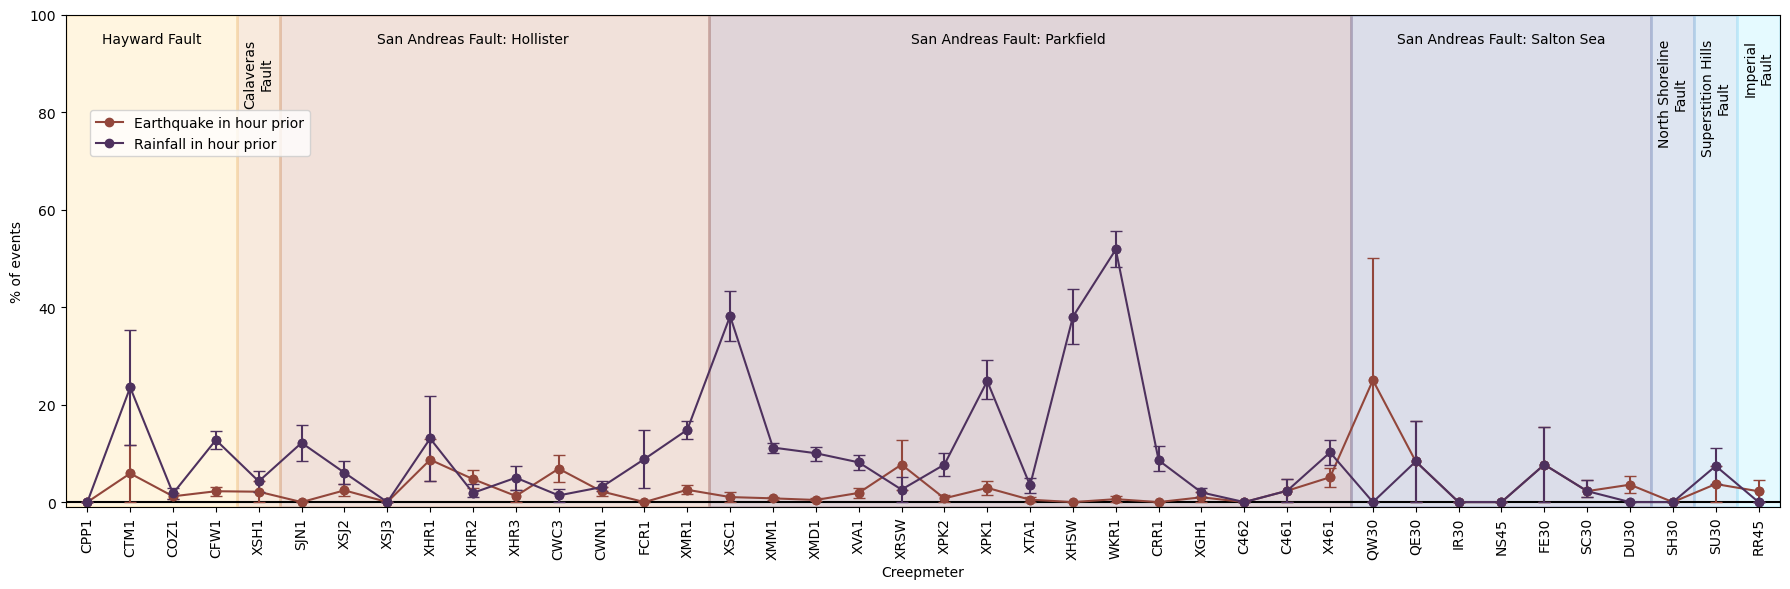

In [76]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,1,1)
#plt.plot(percentage_triggered_all['Latitude'],percentage_triggered_all['percentage in day'])
# Add a rectangle: (x, y) = lower left corner; width and height
rect_Hawyard = patches.Rectangle((-0.5, -1), width=4, height=101, linewidth=2, edgecolor=colours[0], 
                                 facecolor=colours[0],alpha=0.2)
rect_Calaveras = patches.Rectangle((3.5, -1), width=1, height=101, linewidth=2, edgecolor=colours[1], 
                                   facecolor=colours[1],alpha=0.2)
rect_Hollister = patches.Rectangle((4.5, -1), width=10, height=101, linewidth=2, edgecolor=colours[2], 
                                   facecolor=colours[2],alpha=0.2)
rect_Parkfield = patches.Rectangle((14.5, -1), width=15, height=101, linewidth=2, edgecolor=colours[4],
                                    facecolor=colours[4],alpha=0.2)
rect_SoCal = patches.Rectangle((29.5, -1), width=7, height=101, linewidth=2, edgecolor=colours[6], 
                               facecolor=colours[6],alpha=0.2)
rect_NS = patches.Rectangle((36.5, -1), width=1, height=101, linewidth=2, edgecolor=colours[7], 
                            facecolor=colours[7],alpha=0.2)
rect_SU = patches.Rectangle((37.5, -1), width=1, height=101, linewidth=2, edgecolor=colours[8], 
                            facecolor=colours[8],alpha=0.2)
rect_IM = patches.Rectangle((38.5, -1), width=1, height=101, linewidth=2, edgecolor=colours[9], 
                            facecolor=colours[9],alpha=0.2)

plt.xticks(np.arange(len(percentage_triggered_all_eq_boot)),percentage_triggered_all_eq_boot['Creepmeter'],rotation=90)
# Add the patch to the Axes
ax.add_patch(rect_Hawyard)
ax.add_patch(rect_Calaveras)
ax.add_patch(rect_Hollister)
ax.add_patch(rect_Parkfield)
ax.add_patch(rect_SoCal)
ax.add_patch(rect_NS)
ax.add_patch(rect_SU)
ax.add_patch(rect_IM)
plt.hlines(0,-0.5,39.5,colors='k')

lower_err = percentage_triggered_all_eq_boot['median'] - percentage_triggered_all_eq_boot['per_15']
upper_err = percentage_triggered_all_eq_boot['per_85'] - percentage_triggered_all_eq_boot['median']

plt.errorbar(np.arange(len(percentage_triggered_all_eq_boot)), percentage_triggered_all_eq_boot['median'], 
             yerr=[lower_err, upper_err], 
             fmt='o', capsize=4,color=colours[3])

plt.plot(np.arange(len(percentage_triggered_all_eq_boot)),percentage_triggered_all_eq_boot['median'],
         color=colours[3],marker='o',label='Earthquake in hour prior')


lower_err = percentage_triggered_all_rainfall_boot['median'] - percentage_triggered_all_rainfall_boot['per_15']
upper_err = percentage_triggered_all_rainfall_boot['per_85'] - percentage_triggered_all_rainfall_boot['median']

plt.errorbar(np.arange(len(percentage_triggered_all_rainfall_boot)), percentage_triggered_all_rainfall_boot['median'], 
             yerr=[lower_err, upper_err], 
             fmt='o', capsize=4,color=colours[5])

plt.plot(np.arange(len(percentage_triggered_all_rainfall_boot)),percentage_triggered_all_rainfall_boot['median'],
         color=colours[5],marker='o',label='Rainfall in hour prior')

#plt.plot(np.arange(len(percentage_triggered_all_rainfall)),percentage_triggered_all_rainfall['percentage in hour'],
#         color=colours[5],marker='^',label='Rainfall in hour prior')
plt.ylabel("% of events")
plt.xlabel('Creepmeter')
plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.82))
plt.text(1.5,95,'Hayward Fault',verticalalignment='center',horizontalalignment='center')
plt.text(4,95,'Calaveras\nFault', rotation=90,verticalalignment='top',horizontalalignment='center')
plt.text(9,95,'San Andreas Fault: Hollister',verticalalignment='center',horizontalalignment='center')
plt.text(21.5,95,'San Andreas Fault: Parkfield',verticalalignment='center',horizontalalignment='center')
plt.text(33,95,'San Andreas Fault: Salton Sea',verticalalignment='center',horizontalalignment='center')
plt.text(37,95,'North Shoreline\nFault', rotation=90,verticalalignment='top',horizontalalignment='center')
plt.text(38,95,'Superstition Hills\nFault', rotation=90,verticalalignment='top',horizontalalignment='center')
plt.text(39,95,'Imperial\nFault', rotation=90,verticalalignment='top',horizontalalignment='center')
plt.xlim([-0.5,39.5])
plt.ylim([-1,100])
plt.tight_layout()
plt.savefig('../../Creep_catalog_stats_figures/Bootstrapped_percentages_events_rain_or_EQ_in_hour_prior.pdf')
plt.show()


In [117]:
picks['ST']+dt.timedelta(days=365)

0    2024-10-26 06:27:59
1    2024-10-26 17:48:59
2    2024-10-27 03:49:00
3    2024-10-27 12:45:00
4    2024-10-28 13:00:00
5    2025-01-28 09:17:00
6    2025-01-28 20:33:00
7    2025-06-17 16:59:00
8    2025-06-27 16:23:00
9    2025-07-08 17:48:59
10   2025-07-09 16:05:00
11   2025-07-10 16:50:59
12   2025-07-30 08:41:00
13   2025-08-06 03:33:00
14   2025-08-15 08:10:00
15   2025-08-23 15:56:59
16   2025-09-03 20:53:00
17   2025-09-20 19:25:00
18   2025-12-14 23:15:59
19   2025-12-15 11:42:00
20   2025-12-15 20:37:59
21   2025-12-16 19:54:59
22   2025-12-17 12:29:59
23   2025-12-18 14:21:59
24   2025-12-28 13:43:00
25   2025-12-29 14:10:59
26   2025-12-30 04:32:00
27   2025-12-31 01:45:59
28   2026-01-08 07:43:00
29   2026-08-08 16:32:00
30   2026-08-15 13:56:00
31   2026-09-01 14:01:59
32   2026-11-01 22:34:59
33   2026-11-03 14:42:59
34   2026-11-04 14:59:00
35   2026-11-07 13:14:59
36   2026-12-01 21:36:00
37   2026-12-04 08:41:00
38   2026-12-06 13:12:59
39   2026-12-11 19:56:00


In [114]:

from dateutil.relativedelta import relativedelta

def add_one_year(date_value):
  """Adds one year to a date, handling leap years correctly."""
  new_date = date_value + relativedelta(years=1)
  looping = int(str(picks['ST'].iloc[-1])[0:4]) - int(str(picks['ST'].iloc[0])[0:4])
  if new_date > dt.datetime(2024,1,1):
    new_date = new_date - relativedelta(years=looping+1)
  return new_date

In [122]:
picks_test_circle = picks.copy(deep=True)

In [124]:
for i in range(int(str(picks_test_circle['ST'].iloc[-1])[0:4]) - int(str(picks_test_circle['ST'].iloc[0])[0:4])):
    picks_test_circle['ST'] = picks_test_circle['ST'].apply(add_one_year)
    print(picks_test_circle)

   Network Creepmeter_full_name Creepmeter_abbrv  Latitude  Longitude  \
0      CAL          Shore Rd #1             XSH1    36.943   -121.445   
1      CAL          Shore Rd #1             XSH1    36.943   -121.445   
2      CAL          Shore Rd #1             XSH1    36.943   -121.445   
3      CAL          Shore Rd #1             XSH1    36.943   -121.445   
4      CAL          Shore Rd #1             XSH1    36.943   -121.445   
5      CAL          Shore Rd #1             XSH1    36.943   -121.445   
6      CAL          Shore Rd #1             XSH1    36.943   -121.445   
7      CAL          Shore Rd #1             XSH1    36.943   -121.445   
8      CAL          Shore Rd #1             XSH1    36.943   -121.445   
9      CAL          Shore Rd #1             XSH1    36.943   -121.445   
10     CAL          Shore Rd #1             XSH1    36.943   -121.445   
11     CAL          Shore Rd #1             XSH1    36.943   -121.445   
12     CAL          Shore Rd #1             XSH1   

In [118]:
float(str(picks['ST'].iloc[0])[0:4])

2023.0